
# No Show Appointments **Capstone Edition**
Amanda Bowman


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#load">Load and Explore the Data</a></li>
<li><a href="#clean">Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#eda">Preprocessing</a></li> 
<li><a href="#eda">Data Model</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#sources">Sources</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

This dataset is a simplified version of the Medical Appointment No Shows dataset on kaggle. It contains data for 110,527 unique appointments with 14 associated values for different characteristics. It was most recently updated six years ago. One item of note when viewing this dataset is that the value of the No Show column indicates whether the patient no-showed for the appointment. This means that "Yes" or, later, True mean that the patient did NOT attend the appointment.

#### Descriptive information about each column

| Column Name     | Description   | Original Datatype | Final Datatype |
|:-----           |:-----         |:-------           |:--------       |
|PatientId      |Identification of a patient   | float             | string            |
| AppointmentID  | Identification of each appointment         | int               | string            |
| Gender         | Male or Female .    | string            | int         |
| ScheduledDay   | The day someone called or registered the appointment, this should be before appointment.      | string            | datetime       |
| AppointmentDay | The day of the actual appointment, when they have to visit the doctor.                                                                                                                                                 | string            | datetime       |
| Age            | How old is the patient.                                                | int               | int            |
| Neighbourhood  | Where the appointment takes place.                                                 | string            | int           |
| Scholarship    | 0 or 1 .  True indicates enrollment in the social program Bolsa Familia. Between 2003 and 2021, Bolsa Familia supported families with children ages 0-17 living in poverty (monthly income between R$85.01 and R$170.00) and in extreme poverty  (monthly income equal to or less than R$85.00).  Note: To maintain eligibility, children must receive vaccinations on schedule and maintain attendance in school. For children between the ages of 6 and 15, they must meet a 85\%   attendance expectation. Children aged between 16 and 17  must meet a 75\% attendance expectation.  | int               | int           |
| Hipertension   |0 or 1     | int               | int           |
| Diabetes       | 0 or 1     | int               | int           |
| Alcoholism     | 0 or 1     | int               | int           |
| Handcap        | 0-4    | int               | int           |
| SMS_received   | 0 or 1 | int               | int           |
| No-show        | Yes or No. Yes means patient no-showed for the appointment.      | string            | int           |


For additional details about the data set, including the data dictionary:
[kaggle](https://www.kaggle.com/datasets/joniarroba/noshowappointments)
[Project Description](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub)

### Question(s) for Analysis

1) Which factors or characteristics have a positive relationship with no shows? 

2) Is there a relationship between the length of time between scheduling the appointments and appointment attendance? Do people who receive text message reminders attend more frequently and does this relate no shows to the length of time?


### Import the required packages

In [1]:
#!pip install --upgrade pandas==1.3.5
#!pip install --upgrade scikit-learn
#!pip install --upgrade seaborn
#!pip install --upgrade matplotlib

In [2]:
from platform import python_version

print(python_version())

3.8.16


In [3]:
# set up import statements for all of the packages that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

%matplotlib inline

In [4]:
# set some variables
fig_dims = (12,5)

<a id='load'></a>
## Load and Explore the Data

In [5]:
# Load data and print out a few lines to get a basic understanding of the dataset and ensure loading:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:
# Understand basic features of dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [7]:
# View statistical information about the columns.
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


While several of these columns are integers, they appear to represent categorical data. What are the possible values?

In [8]:
columns = ['Gender','Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
for col in columns:
    col_values = str(col) + ': ' + str(pd.unique(df[col])) 
    print(col_values) 
    print()  # cycle through each column and print the concatenated string

Gender: ['F' 'M']

Neighbourhood: ['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIEIRAS'
 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM' 'JARDIM CAMBURI' 'MARIA ORTIZ'
 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA' 'ILHA DE SANTA MARIA'
 'JUCUTUQUARA' 'MONTE BELO' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO' 'BELA VISTA'
 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ' 'UNIVERSITÁRIO'
 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO' 'PARQUE MOSCOSO'
 'DO MOSCOSO' 'SANTOS DUMONT' 'CARATOÍRA' 'ARIOVALDO FAVALESSA'
 'ILHA DO FRADE' 'GURIGICA' 'JOANA D´ARC' 'CONSOLAÇÃO' 'PRAIA DO CANTO'
 'BOA VISTA' 'MORADA DE CAMBURI' 'SANTA LUÍZA' 'SANTA LÚCIA'
 'BARRO VERMELHO' 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE'
 'ENSEADA DO SUÁ' 'SANTOS REIS' 'PIEDADE' 'JESUS DE NAZARETH'
 'SANTA TEREZA' 'CRUZAMENTO' 'IL

In [9]:
# Number of duplicate rows?
sum(df.duplicated())

0

In [10]:
# Missing data?
df.isna().any(axis=1).sum() 

0

In [11]:
# Check the number of unique patients versus the number of unique appointments to determine how these columns relate.
print('Number of unique patients: ', df['PatientId'].nunique())
print('Number of unique appointments: ', df['AppointmentID'].nunique())

Number of unique patients:  62299
Number of unique appointments:  110527


This indicates that each appointment is only linked to one patient, but one patient can have many appointments.

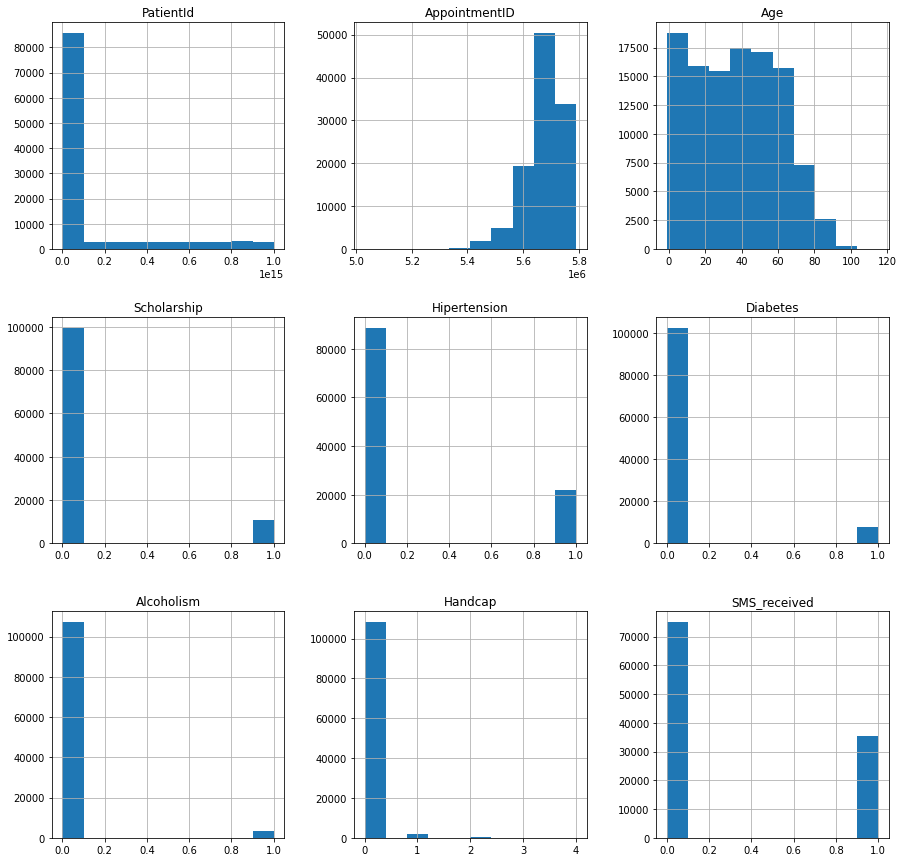

In [12]:
# Histograms of each column to better understand the data and distributions for each column. AppointmentID and PatientId will have no meaning.
df.hist(figsize=(15,15));

In [13]:
def plot_dist(df, col_name, width_bin):
    sns.displot(data=df, x=col_name, binwidth=width_bin, height=5, aspect=11.7/5);

<a id='clean'></a>
## Cleaning and Wrangling

As identified above, there are no duplicate rows and no missing values. My data will require some wrangling before it is ready for use in a model. I will address some general issues and perform initial feature engineering on the date columns.

#### Update Column Names and Drop ID columns

 
 * Column Headers:
     - Capitalized - need to make lower case
     - Need to separate PatientId, AppointmentID, ScheduledDay, AppointmentDay with _
     - Change No-show to no_show     
     - Update Hipertension and Handcap column names
     

     




     - sheduled_day and appointment_day to datetime
     - scholarship, hipertension, diabetes, alcoholism, sms_received, no_show to bool
     


In [14]:
# Make a copy of the data
df_prep = df.copy()

In [15]:
# Make all column names lower case and replace the dash with an underscore.
df_prep.rename(columns= lambda x:x.lower().replace("-", "_"), inplace=True)
# Rename the rest of columns by adding an underscore and update column names. 
df_prep.rename(columns={'scheduledday':'scheduled_day', 'appointmentday':'appointment_day', 'hipertension':'hypertension', 'handcap':'disability_count', 'patientid': 'pt_id', 'appointmentid': 'appt_id'}, inplace=True)
# Check new column names.
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pt_id             110527 non-null  float64
 1   appt_id           110527 non-null  int64  
 2   gender            110527 non-null  object 
 3   scheduled_day     110527 non-null  object 
 4   appointment_day   110527 non-null  object 
 5   age               110527 non-null  int64  
 6   neighbourhood     110527 non-null  object 
 7   scholarship       110527 non-null  int64  
 8   hypertension      110527 non-null  int64  
 9   diabetes          110527 non-null  int64  
 10  alcoholism        110527 non-null  int64  
 11  disability_count  110527 non-null  int64  
 12  sms_received      110527 non-null  int64  
 13  no_show           110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


#### Address Age
 
 Age is an integer variable starting at 0. There were patients aged under 0 and over 100 years old. 115 years old seems like a potential error.

The number of patients between the ages of 100 and 120 is very small. What can I learn about those patients to determine whether they need to be dropped from the dataset as errors?

What are the ages of the patient for the 10 oldest-aged appointments?

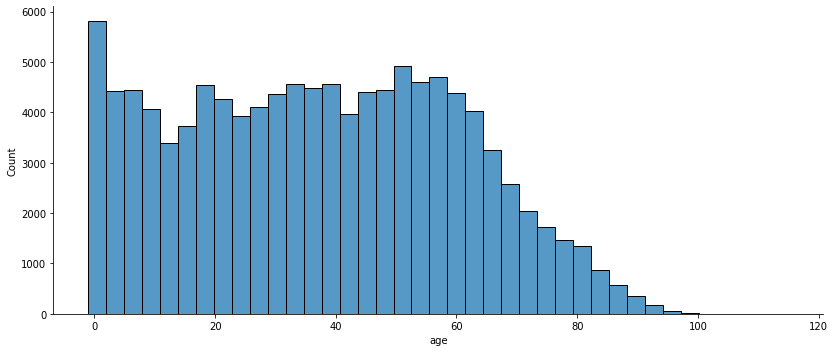

In [16]:
# What does the distribution of ages look like?
plot_dist(df_prep,'age', 3)

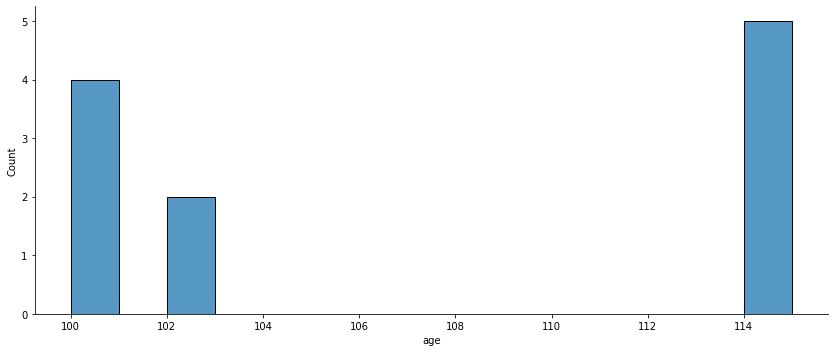

In [17]:
#The number of patients between the ages of 100 and 120 is very small. 
#What can I learn about those patients to determine whether they need to be dropped from the dataset as errors?
plot_dist(df_prep[df_prep['age'] >= 100], 'age', 1)

In [18]:
df_prep[df_prep['age'] >= 102]

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show
58014,9.762948e+14,5651757,F,2016-05-03T09:14:53Z,2016-05-03T00:00:00Z,102,CONQUISTA,0,0,0,0,0,0,No
63912,3.196321e+13,5700278,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
90372,2.342836e+11,5751563,F,2016-05-31T10:19:49Z,2016-06-02T00:00:00Z,102,MARIA ORTIZ,0,0,0,0,0,0,No
97666,7.482346e+14,5717451,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


Based on patientid, the max age of 115 is for two distinct patients, one with multiple appointments. The next oldest is 102. While it is possible that this age is correct, reviewing [World Age Statistics] (https://en.wikipedia.org/wiki/Oldest_people#:~:text=The%20oldest%20living%20person%20in,Venezuela%2C%20born%2027%20May%201909.) indicates it is unlikely to have even one person of this age in this data, let alone two. It is impossible to determine whether these ages were entered in error, so it will be necessary to remove these rows. Since the next oldest patient is 102 and there are 6 patients between the ages of 100 and 102, I will use this as a cutoff. 

In [19]:
df_prep.drop(df_prep[df_prep['age'] > 102].index, inplace = True)
df_prep.drop(df_prep[df_prep['age'] < 0].index, inplace = True)

In [20]:
df_prep['age'].describe()

count    110521.000000
mean         37.085694
std          23.104606
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         102.000000
Name: age, dtype: float64

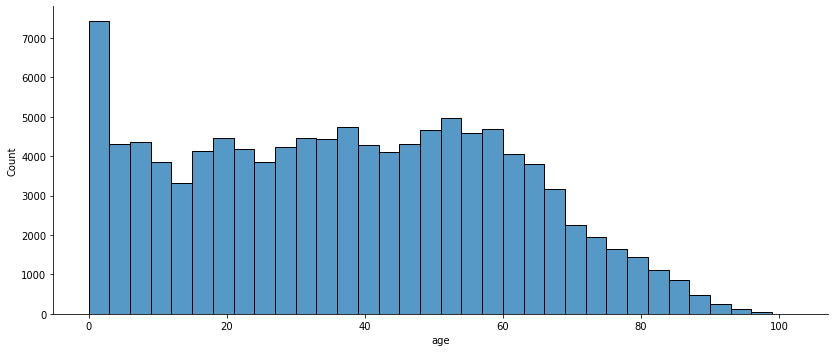

In [21]:
plot_dist(df_prep,'age', 3)

### No Show Rate Feature Engineering
 
While every appointment id is unique, there are duplicate rows for some patients. This means that some patients may have multiple no-shows. Literature shows that past No Shows can be a good indicator of future now shows. As such, it would be helpful to calculate the no show rate for each patient.

 * Need to be converted to DateTime
 * Separate duplicate patients to add a column that processes the number of appointments the patient has had (1) and a binary value for whether they no-shows or not. 
 * Process the duplicate patients by adding a count for each past appointment and a count for each past no-show.
 * Merge the two dataframes and then calculate the no-show rate for each row.

In [22]:
# convert to DateTime
df_prep['scheduled_day'] = pd.to_datetime(df_prep['scheduled_day'])
df_prep['appointment_day'] = pd.to_datetime(df_prep['appointment_day'])
df_prep.head()

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [23]:
# copy df_prep for processing duplicates
df_prep_dup = df_prep.copy()

In [24]:
# split the DataFrame into two DataFrames based on whether the patient had multiple appointments
single_pts = df_prep_dup.drop_duplicates(keep=False)
dup_pts = df_prep_dup[df_prep_dup['pt_id'].duplicated(keep=False)]

In [25]:
# Confirm that all patients are only in the single dataframe once
sum(single_pts.duplicated())

0

In [26]:
# Processing patients with only one appointment
# add a column for the number of appointments the patient had in the data
single_pts['appt_count'] = 1

In [27]:
# confirm new column
single_pts.head()

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appt_count
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,1
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,1
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,1


In [28]:
# add a column to "count" the number of no-shows (either 0 or 1)
single_pts['ns_count'] = single_pts.apply(lambda x: 1 if x['no_show'] == 'Yes'
               else 0, axis=1)

In [29]:
# Process duplicate patients
# view info for original duplicate patients
print(dup_pts.info())
dup_pts.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72603 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   pt_id             72603 non-null  float64            
 1   appt_id           72603 non-null  int64              
 2   gender            72603 non-null  object             
 3   scheduled_day     72603 non-null  datetime64[ns, UTC]
 4   appointment_day   72603 non-null  datetime64[ns, UTC]
 5   age               72603 non-null  int64              
 6   neighbourhood     72603 non-null  object             
 7   scholarship       72603 non-null  int64              
 8   hypertension      72603 non-null  int64              
 9   diabetes          72603 non-null  int64              
 10  alcoholism        72603 non-null  int64              
 11  disability_count  72603 non-null  int64              
 12  sms_received      72603 non-null  int64              
 13  

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No


In [30]:
def count_noshows(dup_df):
    """Adds columns with cumulative count of appointments and no-shows for each patient.
    
    Parameters:
    dup_df: DataFrame with patients with multiple appointments
    
    Returns:
    dup_df: same DataFrame with new columns for appointment and no-show count
    """
    # sort df first by patient id and then by appointment date
    dup_df = dup_df.sort_values(['pt_id', 'appointment_day'])
    
    # group rows by patient id and cumulatively count the number of appointments
    dup_df['appt_count'] = dup_df.groupby('pt_id').cumcount() + 1

    # group rows by patient id and counts the number of no shows for each row
    dup_df['ns_count'] = (dup_df
                            .groupby('pt_id')['no_show']
                          .apply(lambda x: (x == 'Yes')
                          .cumsum())).fillna(0)
    return dup_df

In [31]:
# apply dunction to the duplicate pts df and return a new df
new_dups = count_noshows(dup_pts)

In [32]:
dup_pts.shape

(72603, 14)

In [33]:
# view new dataframe and relevant info
print(new_dups.shape)
new_dups.head(5)

(72603, 16)


,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appt_count,ns_count
58616,22638656.0,5580835,F,2016-04-14 07:23:30+00:00,2016-05-03 00:00:00+00:00,22,INHANGUETÁ,0,0,0,0,0,1,No,1,0
88585,22638656.0,5715081,F,2016-05-18 13:37:12+00:00,2016-06-08 00:00:00+00:00,23,INHANGUETÁ,0,0,0,0,0,1,No,2,0
83628,52168938.0,5704816,F,2016-05-16 16:42:19+00:00,2016-05-16 00:00:00+00:00,28,JARDIM DA PENHA,0,0,0,0,0,0,No,1,0
49826,52168938.0,5607220,F,2016-04-20 11:22:15+00:00,2016-05-17 00:00:00+00:00,28,JARDIM DA PENHA,0,0,0,0,0,0,No,2,0
11009,64851211.0,5683383,F,2016-05-11 07:28:23+00:00,2016-05-13 00:00:00+00:00,29,MARUÍPE,0,0,0,0,0,0,Yes,1,1


In [34]:
# combine the two DataFrames and reassign to df_prep
df_prep = pd.concat([single_pts, new_dups])

In [35]:
print(df_prep.info())
df_prep.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183124 entries, 0 to 104616
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   pt_id             183124 non-null  float64            
 1   appt_id           183124 non-null  int64              
 2   gender            183124 non-null  object             
 3   scheduled_day     183124 non-null  datetime64[ns, UTC]
 4   appointment_day   183124 non-null  datetime64[ns, UTC]
 5   age               183124 non-null  int64              
 6   neighbourhood     183124 non-null  object             
 7   scholarship       183124 non-null  int64              
 8   hypertension      183124 non-null  int64              
 9   diabetes          183124 non-null  int64              
 10  alcoholism        183124 non-null  int64              
 11  disability_count  183124 non-null  int64              
 12  sms_received      183124 non-null  int64    

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appt_count,ns_count
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,1,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,1,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,1,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,1,0


In [36]:
df_prep['noshow_rate'] = df_prep['ns_count'] / df_prep['appt_count']
df_prep.head(10)

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appt_count,ns_count,noshow_rate
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1,0,0.0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,1,0,0.0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,1,0,0.0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,1,0,0.0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,1,0,0.0
5,9.598513e+13,5626772,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No,1,0,0.0
6,7.336882e+14,5630279,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes,1,1,1.0
7,3.449833e+12,5630575,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes,1,1,1.0
8,5.639473e+13,5638447,F,2016-04-29 08:02:16+00:00,2016-04-29 00:00:00+00:00,21,ANDORINHAS,0,0,0,0,0,0,No,1,0,0.0
9,7.812456e+13,5629123,F,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,No,1,0,0.0


In [37]:
df_prep[df_prep['pt_id'].duplicated(keep=False)].sort_values('pt_id').head(10)

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appt_count,ns_count,noshow_rate
58616,22638656.0,5580835,F,2016-04-14 07:23:30+00:00,2016-05-03 00:00:00+00:00,22,INHANGUETÁ,0,0,0,0,0,1,No,1,0,0.0
58616,22638656.0,5580835,F,2016-04-14 07:23:30+00:00,2016-05-03 00:00:00+00:00,22,INHANGUETÁ,0,0,0,0,0,1,No,1,0,0.0
88585,22638656.0,5715081,F,2016-05-18 13:37:12+00:00,2016-06-08 00:00:00+00:00,23,INHANGUETÁ,0,0,0,0,0,1,No,1,0,0.0
88585,22638656.0,5715081,F,2016-05-18 13:37:12+00:00,2016-06-08 00:00:00+00:00,23,INHANGUETÁ,0,0,0,0,0,1,No,2,0,0.0
49826,52168938.0,5607220,F,2016-04-20 11:22:15+00:00,2016-05-17 00:00:00+00:00,28,JARDIM DA PENHA,0,0,0,0,0,0,No,1,0,0.0
83628,52168938.0,5704816,F,2016-05-16 16:42:19+00:00,2016-05-16 00:00:00+00:00,28,JARDIM DA PENHA,0,0,0,0,0,0,No,1,0,0.0
49826,52168938.0,5607220,F,2016-04-20 11:22:15+00:00,2016-05-17 00:00:00+00:00,28,JARDIM DA PENHA,0,0,0,0,0,0,No,2,0,0.0
83628,52168938.0,5704816,F,2016-05-16 16:42:19+00:00,2016-05-16 00:00:00+00:00,28,JARDIM DA PENHA,0,0,0,0,0,0,No,1,0,0.0
11009,64851211.0,5683383,F,2016-05-11 07:28:23+00:00,2016-05-13 00:00:00+00:00,29,MARUÍPE,0,0,0,0,0,0,Yes,1,1,1.0
6674,64851211.0,5697532,F,2016-05-13 16:22:26+00:00,2016-05-17 00:00:00+00:00,29,MARUÍPE,0,0,0,0,0,0,No,2,1,0.5


In [38]:
# Drop appointment and patient id columns
df_prep.drop(columns=['appt_count', 'ns_count'], inplace=True)
df_prep.reset_index(drop=True, inplace=True)
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183124 entries, 0 to 183123
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   pt_id             183124 non-null  float64            
 1   appt_id           183124 non-null  int64              
 2   gender            183124 non-null  object             
 3   scheduled_day     183124 non-null  datetime64[ns, UTC]
 4   appointment_day   183124 non-null  datetime64[ns, UTC]
 5   age               183124 non-null  int64              
 6   neighbourhood     183124 non-null  object             
 7   scholarship       183124 non-null  int64              
 8   hypertension      183124 non-null  int64              
 9   diabetes          183124 non-null  int64              
 10  alcoholism        183124 non-null  int64              
 11  disability_count  183124 non-null  int64              
 12  sms_received      183124 non-null  int64    

### Date Feature Engineering
 
Discrete dates will not be helpful for predicting future no-shows. The day of the week that the appointment was scheduled or that the patient called to schedule may be relevant. Columns with this data will be created. The time lapse between when the appointment is made and the appointment date likely does have a relationship with no shows. A time lapse column will be created to leverage the date information.

 * Need to be converted to DateTime
 * Extract day of the week for `scheduled_day` and `appointment_day`
 * Create new int col for number of days between scheduled and appt
 * Drop date columns

In [39]:
# What is the range of dates for the set?
df_prep['appointment_day'].agg(['min', 'max'])

min   2016-04-29 00:00:00+00:00
max   2016-06-08 00:00:00+00:00
Name: appointment_day, dtype: datetime64[ns, UTC]

In [40]:
# Could the day of the week for scheduling or the appointment day be relevant?
df_prep['appointment_weekday'] = df_prep['appointment_day'].dt.dayofweek
df_prep['scheduled_weekday'] = df_prep['scheduled_day'].dt.dayofweek

In [41]:
df_prep.head()

,pt_id,appt_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0.0,4,4
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0.0,4,4
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,0.0,4,4
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0.0,4,4
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0.0,4,4


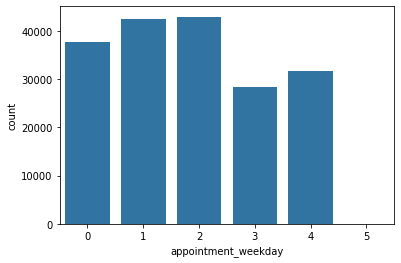

In [42]:
sns.countplot(data=df_prep, x='appointment_weekday');

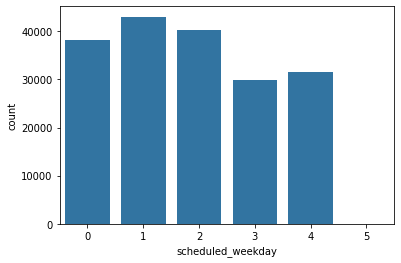

In [43]:
sns.countplot(data=df_prep, x='scheduled_weekday');

In [44]:
# Create new column for the number of days between scheduling and the actual appointment. 
df_prep['days_between'] = (df_prep['appointment_day'] - df_prep['scheduled_day']).dt.days.astype(int)

#View the statistical information about the new column.
df_prep['days_between'].describe()

count    183124.000000
mean          8.814492
std          14.783642
min          -7.000000
25%          -1.000000
50%           3.000000
75%          13.000000
max         178.000000
Name: days_between, dtype: float64

Appointment_day does not have time included but scheduled_day does. This is causing a -1 in days_between. This value should be 0 to indicate that the appointment was scheduled on the same day. Any rows with a negative number after -1 has been replaced with 0 are erroneous and need to be removed.

In [45]:
# Replace rows with -1 for same day with 0
df_prep['days_between'].replace(-1, 0, inplace=True)

In [46]:
# Drop rows with appointment dates prior to scheduling dates
df_prep.drop(df_prep[df_prep['days_between'] < 0].index, inplace = True)

In [47]:
# Verify
df_prep['days_between'].describe()

count    183114.000000
mean          9.164477
std          14.557809
min           0.000000
25%           0.000000
50%           3.000000
75%          13.000000
max         178.000000
Name: days_between, dtype: float64

In [48]:
# Drop date columns
df_prep.drop(columns=['appointment_day', 'scheduled_day'], inplace=True)
df_prep.head()

,pt_id,appt_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,days_between
0,2.987250e+13,5642903,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0.0,4,4,0
1,5.589978e+14,5642503,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0.0,4,4,0
2,4.262962e+12,5642549,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,0.0,4,4,0
3,8.679512e+11,5642828,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0.0,4,4,0
4,8.841186e+12,5642494,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0.0,4,4,0


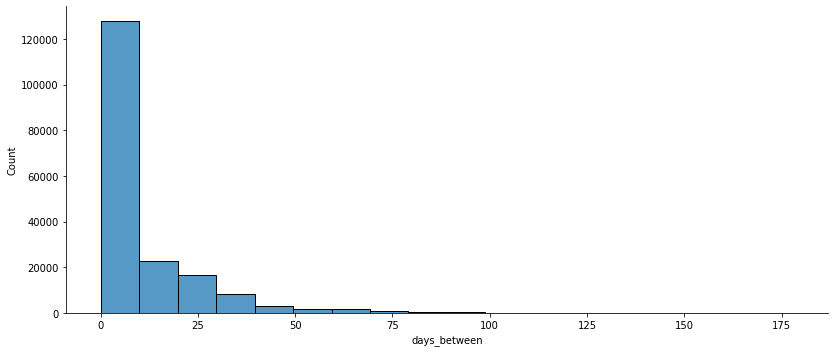

In [49]:
# distribution of days between
# Note: This data is highly skewed and will require transformation
plot_dist(df_prep, 'days_between', 10)

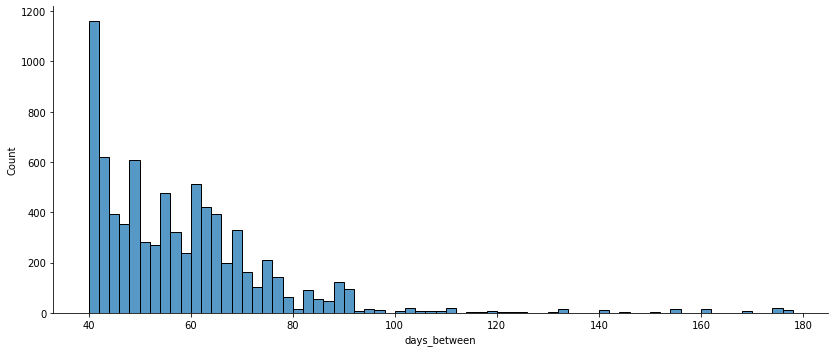

In [50]:
# distribution of days between greater than approximately 2 std above the mean
plot_dist(df_prep[df_prep['days_between'] >= 40], 'days_between', 2)

#### ID Columns
Since each row represents one appointment, I can drop the appointment and patient id columns.

In [51]:
# Drop appointment and patient id columns
df_prep.drop(columns=['appt_id', 'pt_id'], inplace=True)

In [52]:
# Make a pre-dummies dataframe for EDA
df_eda = df_prep.copy()
df_engineer = df_prep.copy()

## Preprocessing

### Continuous Variables
`age` and `days_between` are both continuous variables with a high degree of skew. The skew will cause problems with the model, so this must be addressed.

**Age**

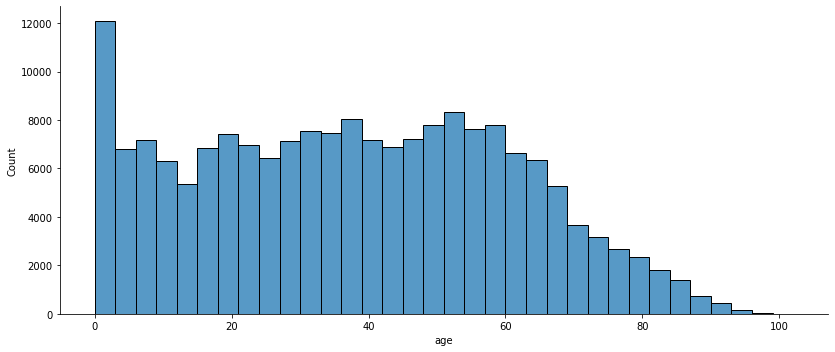

In [53]:
# view distribution of age
plot_dist(df_engineer,'age', 3)

In [54]:
# identify the age bins and labels
age_bins = [0, 1, 5, 17, 28, 44, 54, 65, 75, 102]
age_labels = ['infant', 'preschool', 'child', 'young_adult', 'adult', 'middle_aged', 'mature_adult', 'senior', '80_and_over']
# cut the data into bins
df_engineer['age_range'] = pd.cut(df_engineer['age'], bins=age_bins, labels=age_labels)
df_engineer.head()

,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,days_between,age_range
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0.0,4,4,0,mature_adult
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0.0,4,4,0,mature_adult
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,0.0,4,4,0,mature_adult
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0.0,4,4,0,child
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0.0,4,4,0,mature_adult


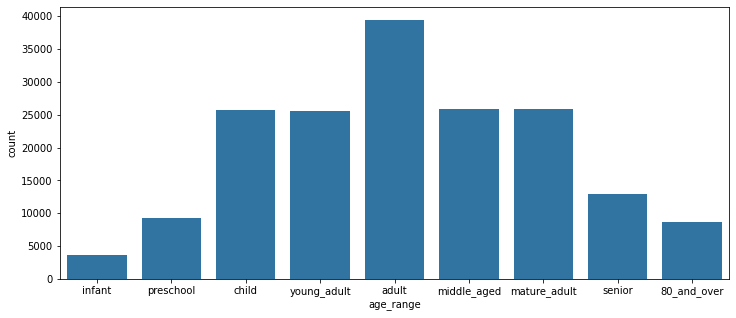

In [55]:
plt.figure(figsize=(12,5))
sns.countplot(data=df_engineer, x='age_range');

**Days Between**

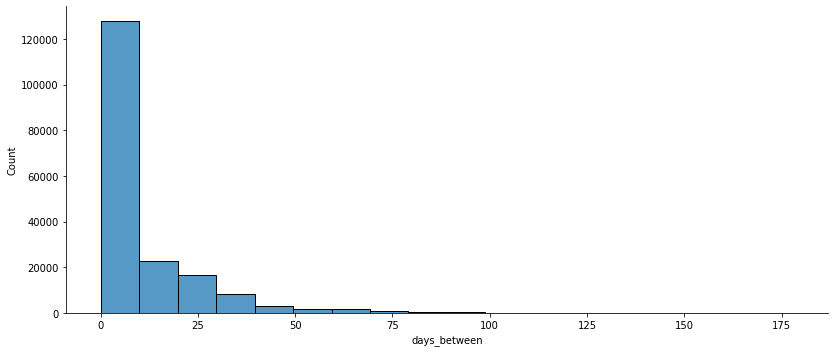

In [56]:
plot_dist(df_engineer, 'days_between', 10)

In [57]:
days_bins = [0, 1, 8, 31, 180]
days_labels = ['same_day', 'first_week', 'one_month', 'greater_than_one_month']
df_engineer['days_range'] = pd.cut(df_engineer['days_between'], bins=days_bins, labels=days_labels, right=False)

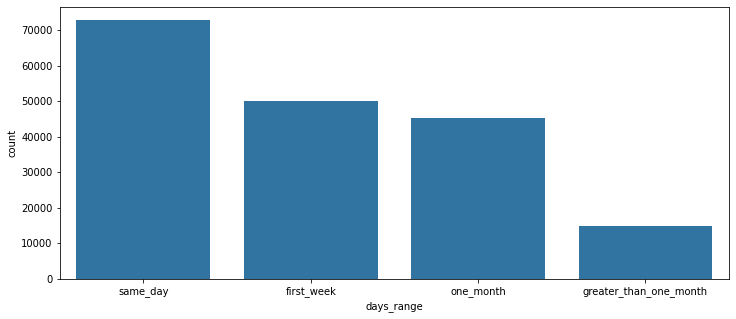

In [58]:
plt.figure(figsize=(12,5))
sns.countplot(data=df_engineer, x='days_range');

#### Disability Count
`disability_count` is an ordinal variable. As it is an int, no further engineering is required.


#### Categorical Variables

The rest of the variables are categorical variables. `scholarship`, `hypertension`, `diabetes`, `alcoholism`, and `sms_received` are already integer binary variables, so they require no additional engineering. `no_show` will need to be converted to a binary column. `gender`, `neighbourhood`, `age_range`, and `days_range` will need One Hot Encoding later for statistical testing.
    

In [59]:
df_engineer.head()

,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,days_between,age_range,days_range
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0.0,4,4,0,mature_adult,same_day
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0.0,4,4,0,mature_adult,same_day
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,0.0,4,4,0,mature_adult,same_day
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0.0,4,4,0,child,same_day
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0.0,4,4,0,mature_adult,same_day


**Map `no_show` to binary values**

In [60]:
df_engineer['no_show'].unique()

array(['No', 'Yes'], dtype=object)

In [61]:
# map no_show to binary values
df_engineer['no_show'] = df_engineer['no_show'].replace({'No': 0, 'Yes': 1})

In [62]:
df_engineer['no_show'].unique()

array([0, 1], dtype=int64)

Review correlation with existing binary variables

In [63]:
df_engineer.corr()[['no_show']].sort_values(by='no_show', ascending=False)

,no_show
no_show,1.000000
noshow_rate,0.925163
days_between,0.180961
sms_received,0.126360
scholarship,0.030353
scheduled_weekday,0.008005
appointment_weekday,-0.001495
alcoholism,-0.003538
disability_count,-0.005642
diabetes,-0.014131


<Axes: >

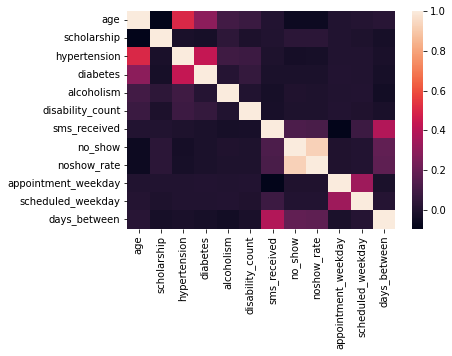

In [64]:
sns.heatmap(df_engineer.corr())

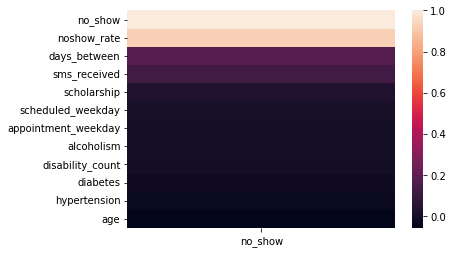

In [65]:
sns.heatmap(df_engineer.corr()[['no_show']].sort_values(by='no_show', ascending=False));

In [66]:
df_engineer = df_engineer.drop(['age', 'days_between'], axis=1)
df_engineer.head()

,gender,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,age_range,days_range
0,F,JARDIM DA PENHA,0,1,0,0,0,0,0,0.0,4,4,mature_adult,same_day
1,M,JARDIM DA PENHA,0,0,0,0,0,0,0,0.0,4,4,mature_adult,same_day
2,F,MATA DA PRAIA,0,0,0,0,0,0,0,0.0,4,4,mature_adult,same_day
3,F,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0.0,4,4,child,same_day
4,F,JARDIM DA PENHA,0,1,1,0,0,0,0,0.0,4,4,mature_adult,same_day


In [67]:
df_engineer = pd.get_dummies(df_engineer, ['gender', 'neighbourhood', 'age_range', 'days_range'])

In [68]:
df_engineer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183114 entries, 0 to 183123
Columns: 106 entries, scholarship to days_range_greater_than_one_month
dtypes: float64(1), int64(9), uint8(96)
memory usage: 36.2 MB


In [69]:
df_engineer.head()

,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_80_and_over,days_range_same_day,days_range_first_week,days_range_one_month,days_range_greater_than_one_month
0,0,1,0,0,0,0,0,0.0,4,4,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0.0,4,4,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0.0,4,4,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0.0,4,4,...,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,0,0,0.0,4,4,...,0,0,0,1,0,0,1,0,0,0


In [79]:
df_engineer.describe()

,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,noshow_rate,appointment_weekday,scheduled_weekday,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_80_and_over,days_range_same_day,days_range_first_week,days_range_one_month,days_range_greater_than_one_month
count,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,...,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000,183114.000000
mean,0.100560,0.197276,0.072381,0.032078,0.022827,0.318124,0.204812,0.202014,1.858192,1.856259,...,0.139853,0.215407,0.141415,0.141284,0.070978,0.047642,0.397763,0.273038,0.247349,0.081851
std,0.300746,0.397944,0.259119,0.176209,0.163359,0.465749,0.403566,0.372319,1.372366,1.380833,...,0.346835,0.411105,0.348450,0.348315,0.256788,0.213009,0.489437,0.445521,0.431472,0.274138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.200000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Selection




In [71]:
from sklearn.feature_selection import chi2

In [80]:
X = df_engineer.drop(['no_show'], axis=1)
y = df_engineer['no_show']
chi_scores = chi2(X, y)
features_chi = pd.DataFrame({'feature': list(X.columns),
                            'chi_score': chi_scores[0],
                            'p_score': chi_scores[1]})
features_chi.head()

,feature,chi_score,p_score
0,scholarship,151.740373,7.220540e-35
1,hypertension,156.202948,7.643973e-36
2,diabetes,33.917668,5.749422e-09
3,alcoholism,2.218345,1.363792e-01
4,disability_count,6.815363,9.037695e-03


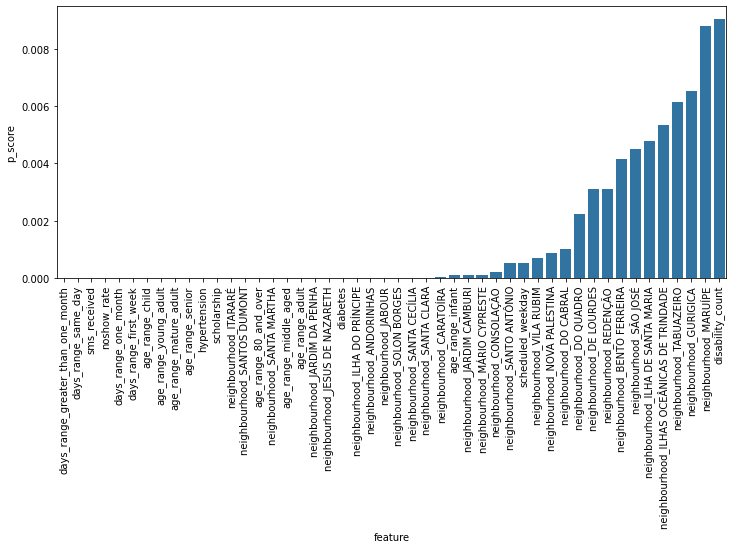

In [81]:
low_p_values = features_chi.query('p_score <= 0.01').sort_values(by='p_score')
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=low_p_values['feature'], y=low_p_values['p_score']);
plt.xticks(rotation='vertical');

In [82]:
low_p_values.shape[0]

48

In [85]:
X.head()

,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,noshow_rate,appointment_weekday,scheduled_weekday,gender_F,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_80_and_over,days_range_same_day,days_range_first_week,days_range_one_month,days_range_greater_than_one_month
0,0,1,0,0,0,0,0.0,4,4,1,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0.0,4,4,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,0,0.0,4,4,1,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0.0,4,4,1,...,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,0,0.0,4,4,1,...,0,0,0,1,0,0,1,0,0,0


In [83]:
high_p_values = features_chi.query('p_score > 0.01')
features_to_drop = list(high_p_values['feature'])
features_to_drop


['alcoholism',
 'appointment_weekday',
 'gender_F',
 'gender_M',
 'neighbourhood_AEROPORTO',
 'neighbourhood_ANTÔNIO HONÓRIO',
 'neighbourhood_ARIOVALDO FAVALESSA',
 'neighbourhood_BARRO VERMELHO',
 'neighbourhood_BELA VISTA',
 'neighbourhood_BOA VISTA',
 'neighbourhood_BONFIM',
 'neighbourhood_CENTRO',
 'neighbourhood_COMDUSA',
 'neighbourhood_CONQUISTA',
 'neighbourhood_CRUZAMENTO',
 'neighbourhood_DA PENHA',
 'neighbourhood_DO MOSCOSO',
 'neighbourhood_ENSEADA DO SUÁ',
 'neighbourhood_ESTRELINHA',
 'neighbourhood_FONTE GRANDE',
 'neighbourhood_FORTE SÃO JOÃO',
 'neighbourhood_FRADINHOS',
 'neighbourhood_GOIABEIRAS',
 'neighbourhood_GRANDE VITÓRIA',
 'neighbourhood_HORTO',
 'neighbourhood_ILHA DAS CAIEIRAS',
 'neighbourhood_ILHA DO BOI',
 'neighbourhood_ILHA DO FRADE',
 'neighbourhood_INHANGUETÁ',
 'neighbourhood_JOANA D´ARC',
 'neighbourhood_JUCUTUQUARA',
 'neighbourhood_MARIA ORTIZ',
 'neighbourhood_MATA DA PRAIA',
 'neighbourhood_MONTE BELO',
 'neighbourhood_MORADA DE CAMBURI',
 '

In [86]:
X.drop(columns=features_to_drop, inplace=True)
X.head()

,scholarship,hypertension,diabetes,disability_count,sms_received,noshow_rate,scheduled_weekday,neighbourhood_ANDORINHAS,neighbourhood_BENTO FERREIRA,neighbourhood_CARATOÍRA,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_80_and_over,days_range_same_day,days_range_first_week,days_range_one_month,days_range_greater_than_one_month
0,0,1,0,0,0,0.0,4,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0.0,4,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,0.0,4,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0.0,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,0.0,4,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [90]:
from scipy.stats import pearsonr

correlation_results = []

# Compute Pearson correlation coefficients and p-values for each feature
for col in X.columns:
    correlation, p_value = pearsonr(X[col], y)
    correlation_results.append((col, correlation, p_value))

In [94]:
# convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results, columns=['feature', 'r', 'p'])
correlation_df.head()

,feature,r,p
0,scholarship,0.030353,1.365950e-38
1,hypertension,-0.032599,3.007817e-44
2,diabetes,-0.014131,1.474791e-09
3,disability_count,-0.005642,1.575602e-02
4,sms_received,0.126360,0.000000e+00


In [99]:
# Filter to see features that have a p value over 0.05
correlation_df[correlation_df['p'] > 0.01]

,feature,r,p
3,disability_count,-0.005642,0.015756


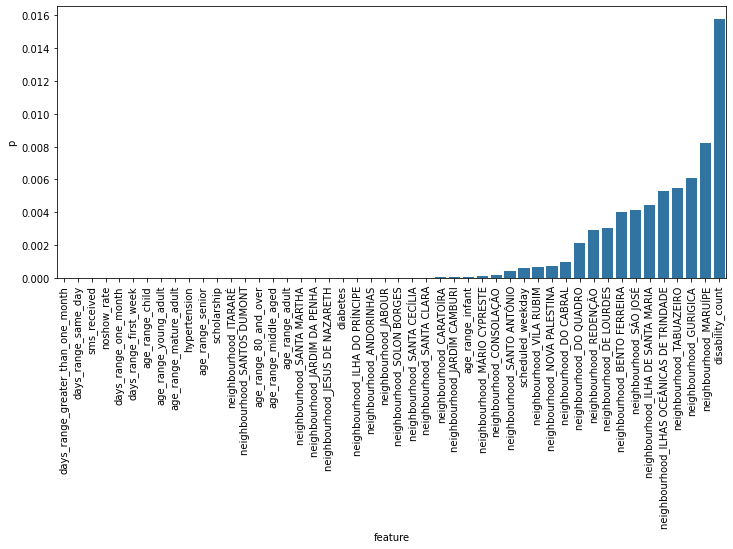

In [102]:
correlation_df.sort_values(by='p', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=correlation_df['feature'], y=correlation_df['p']);
plt.xticks(rotation='vertical');

In [103]:
X.head()

,scholarship,hypertension,diabetes,disability_count,sms_received,noshow_rate,scheduled_weekday,neighbourhood_ANDORINHAS,neighbourhood_BENTO FERREIRA,neighbourhood_CARATOÍRA,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_80_and_over,days_range_same_day,days_range_first_week,days_range_one_month,days_range_greater_than_one_month
0,0,1,0,0,0,0.0,4,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0.0,4,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,0.0,4,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0.0,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,0.0,4,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [104]:
#!pip install imblearn

In [105]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.metrics import classification_report 
from imblearn.under_sampling import InstanceHardnessThreshold
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier


## Training and Prediction

In [106]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Transformed Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Transformed Training set has 146491 samples.
Testing set has 36623 samples.


In [107]:
# Calculate the naive predictor
TP = np.sum(y) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
FP = y.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = TP/y.count()
recall = TP/(TP + FN)
precision = TP/y.count()

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + .25) * ((precision * recall) / ((.25 * precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2048, F-score: 0.2435]


In [108]:
# initiate models
naive_bayes = MultinomialNB()
rf_mod = RandomForestClassifier(random_state=42)
tree_mod = DecisionTreeClassifier(random_state=42)
kneigh_mod = KNeighborsClassifier()

In [109]:
# train models
naive_bayes.fit(X_train, y_train)
rf_mod.fit(X_train, y_train)
tree_mod.fit(X_train, y_train)
kneigh_mod.fit(X_train, y_train)

KNeighborsClassifier()

In [110]:
# predict results
nb_preds = naive_bayes.predict(X_test)
rf_preds = rf_mod.predict(X_test)
tree_preds = tree_mod.predict(X_test)
k_preds = kneigh_mod.predict(X_test)

In [111]:
# Naive Bayes Classification
print(classification_report(y_test, nb_preds))
print(confusion_matrix(y_test, nb_preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29077
           1       0.95      0.81      0.88      7546

    accuracy                           0.95     36623
   macro avg       0.95      0.90      0.92     36623
weighted avg       0.95      0.95      0.95     36623

[[28748   329]
 [ 1397  6149]]


In [112]:
# Random Forest
print(classification_report(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29077
           1       0.91      0.91      0.91      7546

    accuracy                           0.96     36623
   macro avg       0.95      0.94      0.94     36623
weighted avg       0.96      0.96      0.96     36623

[[28431   646]
 [  677  6869]]


In [113]:
# Decision Tree Classifier
print(classification_report(y_test, tree_preds))
print(confusion_matrix(y_test, tree_preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     29077
           1       0.91      0.90      0.90      7546

    accuracy                           0.96     36623
   macro avg       0.94      0.94      0.94     36623
weighted avg       0.96      0.96      0.96     36623

[[28441   636]
 [  789  6757]]


In [114]:
# K-Neighbors Classifier
print(classification_report(y_test, k_preds))
print(confusion_matrix(y_test, k_preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     29077
           1       0.93      0.86      0.90      7546

    accuracy                           0.96     36623
   macro avg       0.95      0.92      0.94     36623
weighted avg       0.96      0.96      0.96     36623

[[28622   455]
 [ 1040  6506]]


### Model Selection
Random Forest has the best overall scores across the board. I will determine if any additional improvements can be made through tuning the model.

In [132]:
# Try tuning K-Neighbors using cross validation
forest = RandomForestClassifier(random_state=42)

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=2)

parameters = {"max_depth": [3, None],
              "n_estimators": list(range(10, 200)),
              "max_features": list(range(1, X_test.shape[1]+1)),
              "min_samples_split": list(range(2, 11)),
              "min_samples_leaf": list(range(1, 11)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
random_obj = RandomizedSearchCV(forest, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
forest_fit = random_obj.fit(X_train, y_train)

# Get the estimator
best_forest = forest_fit.best_estimator_

In [133]:
forest_fit.best_params_

{'n_estimators': 48,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 29,
 'max_depth': 3,
 'criterion': 'entropy',
 'bootstrap': False}

In [134]:
# Random Forest results using the best Randomized Search Parameters
forest_preds = best_forest.predict(X_test)
print(classification_report(y_test, forest_preds))
print(confusion_matrix(y_test, forest_preds))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     29077
           1       0.88      0.96      0.91      7546

    accuracy                           0.96     36623
   macro avg       0.93      0.96      0.95     36623
weighted avg       0.97      0.96      0.96     36623

[[28050  1027]
 [  320  7226]]


In [ ]:
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, rf_preds)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, rf_preds, beta = 2)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, forest_preds2)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, forest_preds2, beta = 2)))

In [135]:
# Retrieve feature importances
importances = best_forest.feature_importances_

# Sort features based on importance scores
sorted_indices = importances.argsort()[::-1]  # Sort in descending order

# Print feature importances
for idx in sorted_indices:
    print(f"Feature: {X_train.columns[idx]}, Importance: {importances[idx]}")

Feature: noshow_rate, Importance: 0.9587236955042955
Feature: days_range_same_day, Importance: 0.034729805336369816
Feature: days_range_one_month, Importance: 0.0035470191358774276
Feature: sms_received, Importance: 0.0011002802076409324
Feature: days_range_first_week, Importance: 0.001094014286605425
Feature: age_range_child, Importance: 0.00046323309055953694
Feature: age_range_young_adult, Importance: 0.00011084638710700374
Feature: age_range_mature_adult, Importance: 8.498051102770219e-05
Feature: neighbourhood_SANTOS DUMONT, Importance: 5.416874826179354e-05
Feature: scheduled_weekday, Importance: 3.39333401024812e-05
Feature: days_range_greater_than_one_month, Importance: 2.0685599779509762e-05
Feature: neighbourhood_ITARARÉ, Importance: 1.4351578115938268e-05
Feature: neighbourhood_JARDIM CAMBURI, Importance: 6.251267542252804e-06
Feature: hypertension, Importance: 5.160896978329445e-06
Feature: neighbourhood_SANTA CLARA, Importance: 3.174595447335547e-06
Feature: disability_cou

In [136]:
# create a DataFrame of features and their importances
important_features = pd.DataFrame({'feature': X_train.columns[sorted_indices],
                                   'importance': importances[sorted_indices]})

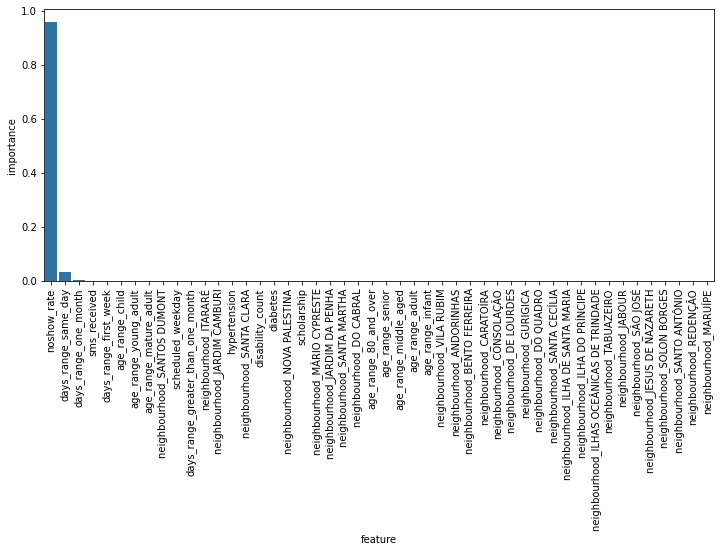

In [137]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=important_features['feature'], y=important_features['importance']);
plt.xticks(rotation='vertical');

<a id='conclusions'></a>
## Conclusions

#### Factors Associated with No Shows

As can be seen in these charts, when the proportions of no shows for different patient characteristics are compared, there are some interesting results. These charts indicate the proportion of patients who have no-showed based on each of the different characteristics available in the dataset, with the exception of neighborhood.

In [ ]:
finalcharts()

In [ ]:
finalagechart()

The proportion of no shows is roughly even for gender and alcoholism status, making it appear that there is little relationship between these characteristics and not attending the appointments.

Having a scholarship or receiving a text message appears to be positively related with not showing up for an appointment.

Having Diabetes or Hypertension have a negative relationship with no shows. Having 1 disability also has a negative relationship with no shows, but it appears that the more disabilities the patient has, the more likely they were to have no showed for their appointment.

Age has a positive skew, indicating that younger patients tend to no show more frequently.

##### Limitations

An important limitation when viewing these charts is that these are all univariate analyses. In reality, the appointments actually represent patients with multiple characteristics that would interact. For example, a patient with diabetes, hypertension and alcoholism may look very different from a patient with just diabetes and hypertension. In addition, these are correlational rather than causal relationships. Performing analyses between how all of these factors interact, particularly in situations where patients may have multiple characteristics, would be interesting future research.

#### SMS Messages and No Shows

The SMS Received relationship with no shows is really interesting. We would definitely expect patients who receive text message reminders to be more likely to attend their appointments. However, since the chart above only explores the relationship between no shows and receipt of a text message, it does not take into consideration other factors that could very much impact the relationships. One thing to be aware of from reviewing the data related to the number of days between scheduling the appointment and the appointment, itself, is that SMS messages were not sent for patients who scheduled their appointment on the same day as the appointment. Since appointments scheduled on the same day of the appointment accounted for a large number of the appointments, it is helpful to dig deeper to see if receiving a text message reminder is actually more likely to be associated with having missed the appointment.

In [ ]:
finalSMSChart()

As can be seen here, receiving a SMS Reminder appears to have a more positive relationship with no shows than not receiving one.

##### Limitations

As with above, this is a shallow view of the data that does not take all of the interactions between the different patient characteristics into consideration. It is possible that SMS Reminders might show more of a positive relationship for a certain subset of the population who would otherwise be unlikely to attend. It is also possible that they may have no correlation at all for another subset. Critically, we cannot draw any causal relationships between receiving a text message reminder and appointment attendance based on these analyses. In order to draw more valid conclusions, additional research and analysis that compares the different patient characteristics would also be helpful.

<a id='sources'></a>
## Sources

To understand the Scholarship column, which indicates enrollment in Bolsa Familia 
[Wikipedia Article](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) 
[World Without Poverty Bolsa Familia Webpage](http://wwp.org.br/en/social-policy/bolsa-familia/) 
[World Without Poverty Bolsa Familia Program Sheet](inthttps://wwp.org.br/wp-content/uploads/02.-BFP-Program-Sheet.pdf)

For additional details about the data set, including the data dictionary:
https://www.kaggle.com/datasets/joniarroba/noshowappointments

For Markdown:
https://wordpress.com/support/markdown-quick-reference/
https://www.markdownguide.org/extended-syntax/
https://www.tablesgenerator.com/markdown_tables#
https://stackoverflow.com/questions/51573722/nested-numbered-list-do-not-break-line-in-jupyter-notebook-markdown

For plotting:
Pie Charts: https://matplotlib.org/2.0.2/examples/pie_and_polar_charts/pie_demo_features.html
Line Chart: https://www.statology.org/plot-multiple-lines-matplotlib/

For figures:
https://www.tutorialspoint.com/setting-the-same-axis-limits-for-all-subplots-in-matplotlib
https://matplotlib.org/stable/users/explain/figures.html#figure-explanation
https://matplotlib.org/stable/gallery/ticks/tick-locators.html

## OPTIONAL: Question for the reviewer
 
If you have any question about the starter code or your own implementation, please add it in the cell below. 

For example, if you want to know why a piece of code is written the way it is, or its function, or alternative ways of implementing the same functionality, or if you want to get feedback on a specific part of your code or get feedback on things you tried but did not work.

Please keep your questions succinct and clear to help the reviewer answer them satisfactorily. 

> **_Your question_**

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])